In [40]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr
import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE')

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater

#import mapfxn as mf
#reload(mf)

plt.rcParams.update({'font.size': 12})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 12}

plt.rc('font', **font)

In [41]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


# using WOA2005 for testing

## metadata notes:

The dataset I'm using here is: (World Ocean Atlas 2005, I assume)
    
    tdat = xr.open_dataset('/gpfs/data/greenocean/software/temp/greenocean-lgmacvol1/data/OCNOBS/WOA2005/Chl/ORCA2_WOAchl_all_iderror.nc')

It is binned to our model grid, which is lovely.

I assume it is coming from this very parseable text/csv thing in the same folder:

    WOA2005chl.txt

there are some ferret and interp files kicking about in that folder: - maybe they could be leveraged against the new WOA 2018?


## questions -

I assume WOA means world ocean atlas, but WOA doesn't traditionally include in-situ chlorophyll - so where is this data from?

https://www.ncei.noaa.gov/access/world-ocean-atlas-2018/

In [42]:
tdat = xr.open_dataset('/gpfs/data/greenocean/software/temp/greenocean-lgmacvol1/data/OCNOBS/WOA2005/Chl/ORCA2_WOAchl_all_iderror.nc')

tmesh = xr.open_dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')
tmask = tmesh['tmaskutil'][0,:,:] 
# print(tmesh)
# tdat['CHL']

### quick summary of available observations - they are sparse...

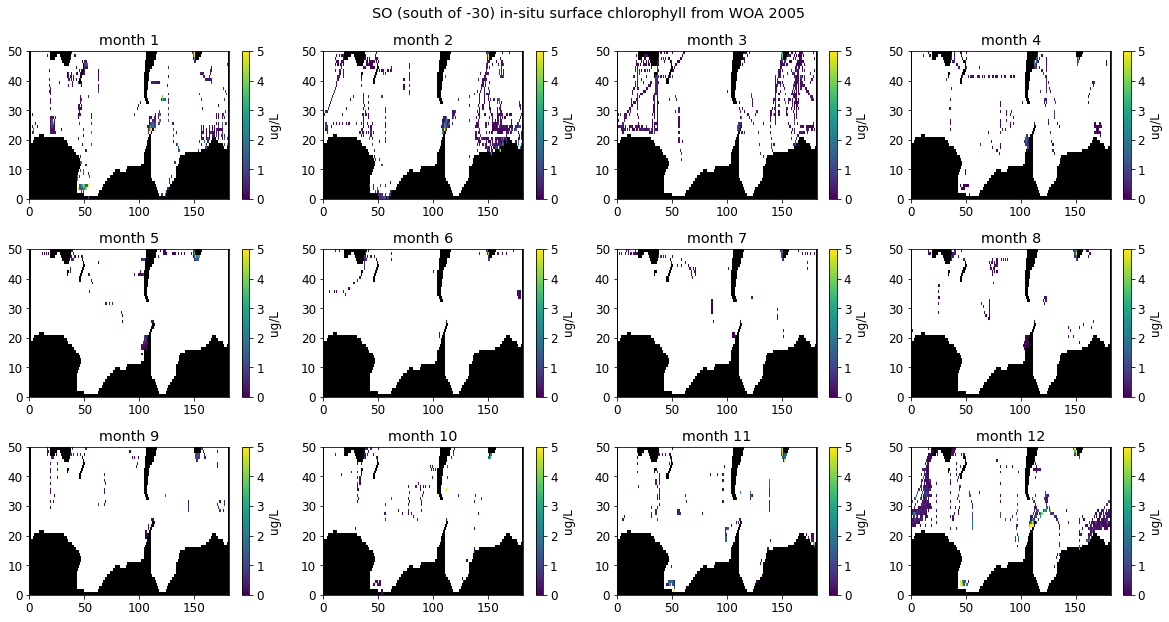

In [43]:
#plt.pcolormesh(tdat['CHL'][0,0,0:50,:])

fact = 1.1
fig, axs = plt.subplots(3,4, figsize=(15*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

for i in range(0,12):
    q = axs[i].pcolormesh(tmask[0:50,:], vmin = 0, vmax = 1, cmap = 'Greys_r')
    q = axs[i].pcolormesh(tdat['CHL'][i,0,0:50,:], vmin = 0, vmax = 5)
    plt.colorbar(q, ax = axs[i], label = 'ug/L')
    axs[i].set_title(f'month {i+1}')
plt.suptitle('SO (south of -30) in-situ surface chlorophyll from WOA 2005')
plt.tight_layout()

In [44]:
#sum of all things 

chl_dp = np.zeros([2884,31])
mons_ar = np.zeros([2884])
ys_ar = np.zeros([2884])
xs_ar = np.zeros([2884])

tot = 0; ind = 0
for i in range(0,12):
    test_chl = tdat['CHL'][i,:,0:50,:]
    q = np.where(~np.isnan(test_chl[0,:,:]))
    xs = q[1]; ys = q[0]
        
    for d in range(0,len(q[1])):
        chl_dp[ind,:] = test_chl[:,ys[d],xs[d]]
        mons_ar[ind] = i+1
        ys_ar[ind] = ys[d]; xs_ar[ind] = xs[d]
        ind = ind+1
        
    tot = tot+(np.shape((np.where(~np.isnan(test_chl[0,:,:]))))[1])
print(tot)

#print(chl_dp[2883,:])

2884


In [45]:

seas_ar = np.zeros_like(mons_ar)
seas_ar[(mons_ar == 12) | (mons_ar <3)] = 1 #summer
seas_ar[(mons_ar >= 3) & (mons_ar <6)] = 2 #autumn
seas_ar[(mons_ar >= 6) & (mons_ar <9)] = 3 #winter
seas_ar[(mons_ar >= 9) & (mons_ar <12)] = 4 #spring 
seascol = ['darkgreen', 'darkorange', 'darkgrey', 'yellowgreen']

In [46]:
bounds = np.array([0,7,16,22,28,32,37,40,44,47,50])
bounds = np.array([0,16,28,37,44,50])
starts = np.zeros([5]); ends = np.zeros([5])
startslat = np.zeros([5]); endslat = np.zeros([5])
print('here are the (python) y-indices and latitude bounds for my latitude bands:')
for i in range(0,len(bounds)-1):
    s= np.format_float_positional(tmesh['nav_lat'][bounds[i],0].values, precision=1)
    e= np.format_float_positional(tmesh['nav_lat'][bounds[i+1],0].values, precision=1)
    bs = bounds[i]
    be = bounds[i+1]
    print(f'band {i}, {(s)} to {e}, index {bs} to {be}')
    starts[i] = s
    ends[i] = e
    startslat[i] = bs
    endslat[i] = be     
# print(starts)
# print(ends)

here are the (python) y-indices and latitude bounds for my latitude bands:
band 0, -78.2 to -69.5, index 0 to 16
band 1, -69.5 to -59.3, index 16 to 28
band 2, -59.3 to -48.8, index 28 to 37
band 3, -48.8 to -38.7, index 37 to 44
band 4, -38.7 to -28.7, index 44 to 50


In [47]:
def custhist(tdat, nbins, start, end, tweights = None):
    #bins = 25
    hist_met_vflx, bins = np.histogram(np.ravel(tdat), bins=nbins,\
                                 range = [start, end], weights=tweights)

    bin_cent = bins + (bins[1]-bins[0])/2
    tot_count = np.sum(hist_met_vflx)

    
    binsback = bins
    bin_cent = bin_cent[0:nbins]
    histback = hist_met_vflx/tot_count
    
    return binsback, bin_cent, histback
    

## quick by-latitude and by-season histograms of available data

with all usual caveats of doing stats on random sparse data

## surface only

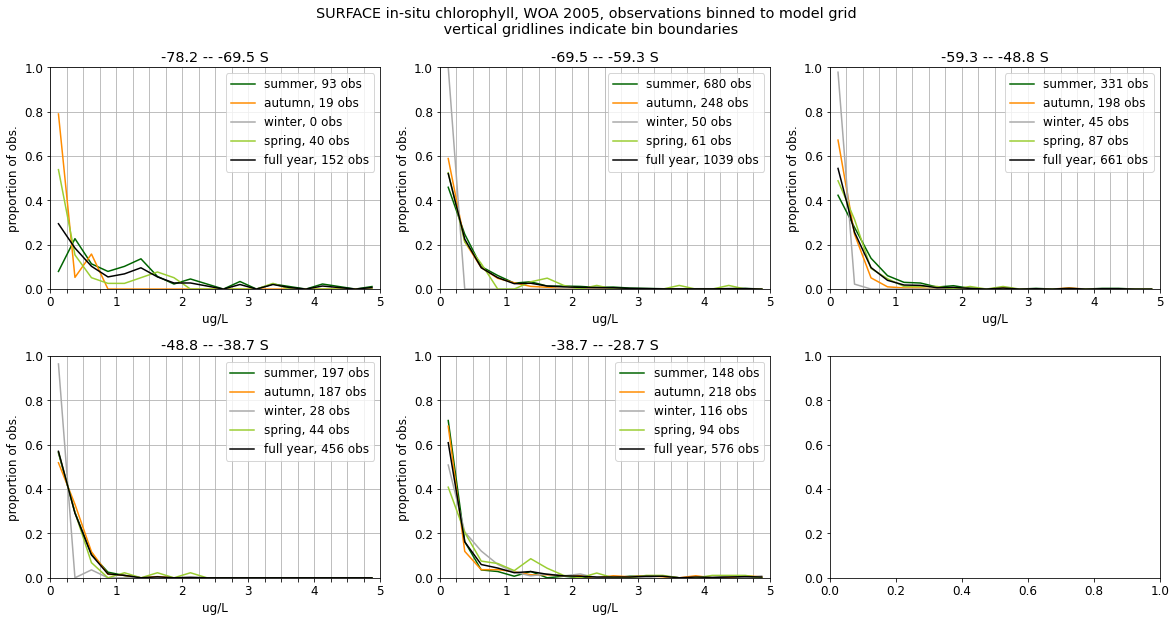

In [48]:
seascol = ['darkgreen', 'darkorange', 'darkgrey', 'yellowgreen']
seasons = ['summer', 'autumn', 'winter', 'spring']

nbins = 20; start = 0; end = 5

fact = 1.1
fig, axs = plt.subplots(2,3, figsize=(15*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()
tw = 0
for i in range(0,5):
    for s in range(1,5):
        ss = np.where(( ys_ar >= bounds[i]) & (ys_ar < bounds[i+1]) & (seas_ar == s))
        t_chl = chl_dp[ss,0]
        
        nobs = (np.shape(np.ravel(t_chl)))
        nobs = (nobs[0])
        binsback, bin_cent, histback = custhist(np.ravel(t_chl), nbins, start, end)
        axs[i].plot(bin_cent, histback, color = seascol[s-1], label = f'{seasons[s-1]}, {nobs} obs')
        axs[i].legend(loc = 'best')
    ss = np.where(( ys_ar >= bounds[i]) & (ys_ar < bounds[i+1]))
    t_chl = chl_dp[ss,0]

    nobs = (np.shape(np.ravel(t_chl)))
    nobs = (nobs[0])
    binsback, bin_cent, histback = custhist(np.ravel(t_chl), nbins, start, end)
    axs[i].plot(bin_cent, histback, color = 'k', label = f'full year, {nobs} obs')
    axs[i].legend(loc = 'best')
    
binslab = ['0',   '','','', '1',   '','','', '2',    '','','', '3',    '','','', '4' , '','','', '5'  ]
for i in range(0,5):
    axs[i].set_xticks(binsback)
    axs[i].set_xticklabels(binslab)
    axs[i].grid()
    axs[i].set_xlim([0,5])
    axs[i].set_ylim([0,1])
    axs[i].set_xlabel('ug/L')
    axs[i].set_ylabel('proportion of obs.')
    
    axs[i].set_title(f'{starts[i]} -- {ends[i]} S') 
plt.suptitle('SURFACE in-situ chlorophyll, WOA 2005, observations binned to model grid \n vertical gridlines indicate bin boundaries')
plt.tight_layout()

## top 105 meters

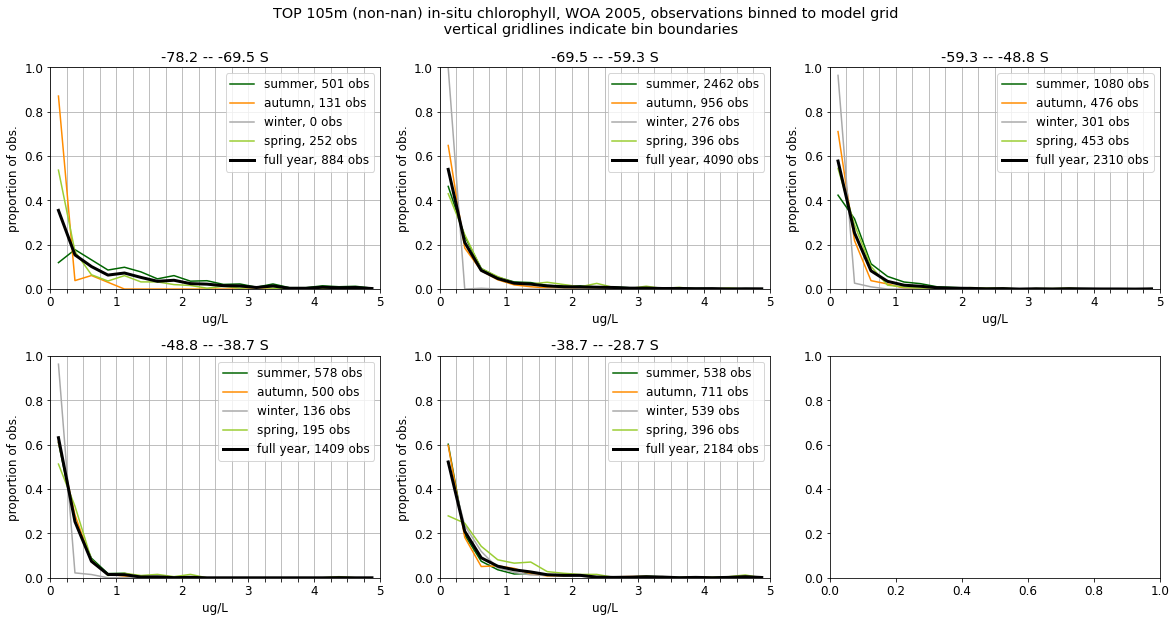

In [49]:
seascol = ['darkgreen', 'darkorange', 'darkgrey', 'yellowgreen']
seasons = ['summer', 'autumn', 'winter', 'spring']

nbins = 20; start = 0; end = 5

fact = 1.1
fig, axs = plt.subplots(2,3, figsize=(15*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()
tw = 0
for i in range(0,5):
    for s in range(1,5):
        ss = np.where(( ys_ar >= bounds[i]) & (ys_ar < bounds[i+1]) & (seas_ar == s))
        t_chl = chl_dp[ss,0:11]
        t_chl = t_chl[~np.isnan(t_chl)]
        
        nobs = (np.shape(np.ravel(t_chl)))
        nobs = (nobs[0])
        binsback, bin_cent, histback = custhist(np.ravel(t_chl), nbins, start, end)
        axs[i].plot(bin_cent, histback, color = seascol[s-1], label = f'{seasons[s-1]}, {nobs} obs')
        axs[i].legend(loc = 'best')
    ss = np.where(( ys_ar >= bounds[i]) & (ys_ar < bounds[i+1]))
    t_chl = chl_dp[ss,0:11]
    t_chl = t_chl[~np.isnan(t_chl)]
    nobs = (np.shape(np.ravel(t_chl)))
    nobs = (nobs[0])
    binsback, bin_cent, histback = custhist(np.ravel(t_chl), nbins, start, end)
    axs[i].plot(bin_cent, histback, color = 'k', label = f'full year, {nobs} obs', linewidth = 3)
    axs[i].legend(loc = 'best')
    
binslab = ['0',   '','','', '1',   '','','', '2',    '','','', '3',    '','','', '4' , '','','', '5'  ]
for i in range(0,5):
    axs[i].set_xticks(binsback)
    axs[i].set_xticklabels(binslab)
    axs[i].grid()
    axs[i].set_xlim([0,5])
    axs[i].set_ylim([0,1])
    axs[i].set_xlabel('ug/L')
    axs[i].set_ylabel('proportion of obs.')
    
    axs[i].set_title(f'{starts[i]} -- {ends[i]} S') 
plt.suptitle('TOP 105m (non-nan) in-situ chlorophyll, WOA 2005, observations binned to model grid \n vertical gridlines indicate bin boundaries')
plt.tight_layout()

In [50]:
print('compute complete')

compute complete
